In [123]:
CALI_PROCESSED = r"..\..\data\processed\california_auto_processed.csv"
CALI_RAW_LISTING = r"..\..\data\raw\california_listings.csv"
CALI_RAW_REVIEWS = r"..\..\data\raw\california_reviews.csv"
REPO_DIR = r"C:\Users\grego\Documents\GitHub\DS440CapstoneIndubitably"
MODEL_FP = r"C:\Users\grego\Documents\GitHub\DS440CapstoneIndubitably\models\knn_random_oversample.pkl"

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append(REPO_DIR)
from app_new.feature_engineering import DemoClassifier
from dataclasses import dataclass
import numpy as np

@dataclass
class Feature:
    data: pd.DataFrame | np.ndarray
    col: str
    type: str
    models: dict | None
    params: dict | None

    def __str__(self):
        return f"{self.type} ({self.col}) - {self.params}"

    __repr__ = __str__

## Load data and model

In [125]:
cali = pd.read_csv(CALI_PROCESSED)
cali.head()

,review_id,listing_id,description,comments,sentiment,label,name,amenities
0,120328835,9225,"['unique', 'guest', 'suite', 'spacious', 'art'...","['host', 'very', 'nice', 'lady', 'however', 'e...",1.8,mbad,"['artful', 'potrero', 'separate', 'floor', 'ga...","['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche..."
1,18794308,9225,"['unique', 'guest', 'suite', 'spacious', 'art'...","['husband', 'stayed', 'gae', 'mel', '5', 'nigh...",4.0,mgood,"['artful', 'potrero', 'separate', 'floor', 'ga...","['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche..."
2,155950,9225,"['unique', 'guest', 'suite', 'spacious', 'art'...","['drove', 'six', 'hour', 'park', 'spot', 'righ...",4.0,good,"['artful', 'potrero', 'separate', 'floor', 'ga...","['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche..."
3,173992,9225,"['unique', 'guest', 'suite', 'spacious', 'art'...","['girlfriend', 'amazing', 'time', 'staying', '...",4.0,good,"['artful', 'potrero', 'separate', 'floor', 'ga...","['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche..."
4,1490950,9225,"['unique', 'guest', 'suite', 'spacious', 'art'...","['amazing', 'inspiring', 'place', 'like', 'mus...",4.5,good,"['artful', 'potrero', 'separate', 'floor', 'ga...","['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche..."


In [126]:
# KEY ERROR: THESE NEED TO BE CONVERTED TO LISTS
cali.description = cali.description.apply(eval)
cali.comments = cali.comments.apply(eval)
cali.amenities = cali.amenities.apply(eval)
cali["name"] = cali["name"].apply(eval)

In [127]:
# load model
model = pickle.load(open(MODEL_FP, "rb"))
model

{'model': KNeighborsClassifier(leaf_size=10, n_neighbors=3),
 'combo': (amenities (amenities) - {'corr_thresh': 0.05, 'amenities': ['amenity005_lockbox', 'amenity005_pool', 'amenity005_dishwasher', 'amenity005_tv', 'amenity005_keypad', 'amenity005_kitchen', 'amenity005_breakfast']},
  pca (comments) - {'n_components': 5, 'vector_size': 50},
  pca (description) - {'n_components': 10, 'vector_size': 1000})}

## Predict and evaluate

In [128]:
clf = DemoClassifier(MODEL_FP)
y_pred, probabilities, X_cali = clf.predict_all_processed(cali)
y_pred = pd.Series(y_pred)

Loading models...
Predicting on 955 rows...
Processing row 1 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 2 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 3 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 4 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 5 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 6 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 7 of 955...
Generating amenities features...
Generating pca features...
...without amenities
...without amenities
Processing row 8 of 955...
Generating amenities featu

KNeighborsClassifier(leaf_size=10, n_neighbors=3)
amenities (amenities) - {'corr_thresh': 0.05, 'amenities': ['amenity005_lockbox', 'amenity005_pool', 'amenity005_dishwasher', 'amenity005_tv', 'amenity005_keypad', 'amenity005_kitchen', 'amenity005_breakfast']}
pca (comments) - {'n_components': 5, 'vector_size': 50}
pca (description) - {'n_components': 10, 'vector_size': 1000}
Californian accuracy: 65.03%


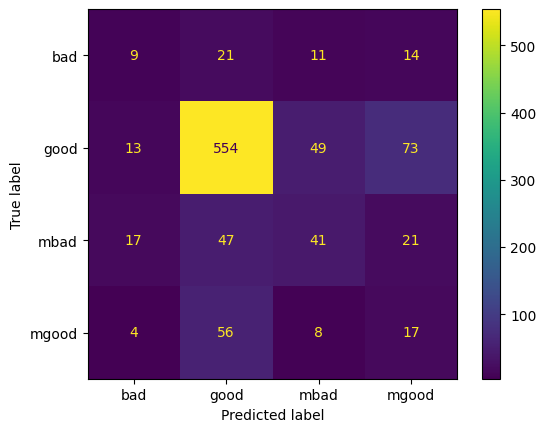

In [131]:
BINARY_LABELS = False

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# load model
with open(MODEL_FP, "rb") as f:
    model = pickle.load(f)

# print info about model and features
print(model["model"])
for feature in model["combo"]:
    print(feature)

if BINARY_LABELS:

    # combine mgood and mbad into "misleading" and good and bad into "not misleading"
    cali_adj = cali.copy()
    y_pred_adj = y_pred.copy()
    cali_adj.label = cali_adj.label.replace({"mgood": "misleading", "mbad": "misleading", "good": "not misleading", "bad": "not misleading"})
    y_pred_adj = y_pred_adj.replace({"mgood": "misleading", "mbad": "misleading", "good": "not misleading", "bad": "not misleading"})

    cm = ConfusionMatrixDisplay.from_predictions(cali_adj.label, y_pred_adj)

    # calculate the accuracy
    accuracy = accuracy_score(cali_adj.label, y_pred_adj)
    print(f"Californian accuracy: {accuracy:.2%}")

else:

    cm = ConfusionMatrixDisplay.from_predictions(cali.label, y_pred)

    # calculate the accuracy
    accuracy = accuracy_score(cali.label, y_pred)
    print(f"Californian accuracy: {accuracy:.2%}")

plt.show()

In [132]:
if BINARY_LABELS:

    true = cali_adj.label.value_counts()
    pred = y_pred_adj.value_counts()
    # calculate accuracy
    print("Accuracy:", accuracy_score(cali_adj.label, y_pred_adj))
else:
    true = cali.label.value_counts()
    pred = y_pred.value_counts()
    # calculate accuracy
    print("Accuracy:", accuracy_score(cali.label, y_pred))



# combine into a dataframe, with labels for true or predicted
true_df = pd.DataFrame({"count": true, "type": "true"})
pred_df = pd.DataFrame({"count": pred, "type": "pred"})
label_compare = pd.concat([true_df, pred_df]).reset_index()

# rename the index column to label
label_compare.rename(columns={"index": "label"}, inplace=True)
label_compare

# plot the counts
import plotly.express as px

fig = px.bar(label_compare, x="label", y="count", color="type", barmode="group")
fig.update_layout(title="True vs. Predicted Labels")
fig.show()

Accuracy: 0.650261780104712


## Generate a "Misleading" score for a listing from the predictions

In [99]:
listing_id_and_prediction = pd.DataFrame({"listing_id": cali.listing_id, "prediction": y_pred})

# load the raw listing data
cali_raw = pd.read_csv(CALI_RAW_LISTING, encoding="unicode_escape")
cali_reviews = pd.read_csv(CALI_RAW_REVIEWS)

def word_wrap(text, width=20):
    text = text.split(" ")
    """Wrap text to a specified width."""
    for i in range(0, len(text), width):
        line = " ".join(text[i:i+width])
        # check if line is empty or only contains whitespace
        if line.strip() == "":
            continue
        # remove newliens
        line = line.replace("\n", "")
        print(" ".join(text[i:i+width]))

def display_listing_with_score(listing_info, review_labels, reviews):
    print(f"Listing ID: {listing_info.id}")
    name = listing_info["name"]
    print(f"Listing Name: {name}")
    print(f"\nListing Description:")
    description = listing_info.description
    # break up the decsription into list of words
    word_wrap(description, 20)
    
    print(f"\nListing Amenities:")
    amenities = listing_info.amenities
    amenities = amenities.replace("{", "").replace("}", "").replace('"', "")
    print(amenities.split(","))

    score = 0
    for label in review_labels:
        if "m" in label:
            score += 1
    

    percent = score / len(review_labels)
    print(f"\nScore: {score} / {len(review_labels)} ({percent:.2%}) of the reviews claim that this listing is misleading.")

    print("----------------------------------------")
    print("\nReviews:")
    for label, review in zip(review_labels, reviews.comments):
        review = review.replace("_x000D_", "")
        print(f"LABEL: {label}")
        word_wrap(review, 20)
        print()
          


from random import choice

# get a random listing
random_listing_id = cali.iloc[choice(cali.index)].listing_id
random_listing = cali_raw[cali_raw.id == random_listing_id]

# get the labels for that listing's reviews
random_listing_comments = cali[cali.listing_id == random_listing_id].index
random_listing_comments_labels = y_pred[random_listing_comments]

# get the reviews themselves
random_listing_comments_ids = cali.iloc[random_listing_comments].review_id
random_listing_reviews = cali_reviews[cali_reviews.id.isin(random_listing_comments_ids)]


display_listing_with_score(cali_raw.iloc[0], random_listing_comments_labels, random_listing_reviews)

Listing ID: 958
Listing Name: Bright, Modern Garden Unit - 1BR/1B

Listing Description:
New update: the house next door is under construction and there is the possibility of noise from 7am - 5pm.
Our rates are discounted during this time period. Our bright garden unit overlooks a grassy backyard area with fruit trees
and native plants. It is an oasis in a big city. The apartment comfortably fits a couple or small family.
It is located on a cul de sac street that ends at lovely Duboce Park. Newly remodeled, modern, and bright
garden unit in historic Victorian home.  *New fixtures and finishes. *Organic cotton sheets and towels. *Zero VOC and non-toxic
Yolo paint. *Organic and fair-trade teas, fresh local ground coffee. *Local art on walls. *Sofa bed and Queen bed are
in the same room. More of a petite apartment with a separate room for dining and kitchen. *Full access to
patio and backyard (shared with us and our dog who live upstairs) *Beautiful garden with fruit trees, native plants a